# Naive bayes on Amazon Food Reviews Dataset

In [2]:
# importing library
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
#creating new datasets after applying filter on reviews dataset

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
# with the help of this method returning positive and negative based on the score

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
print(filtered_data.shape) #looking at the size of the data
filtered_data.head() # top five reviews, just for understanding 

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# delete the reviews which is same on the basis of few features 
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape # after deleting, look at shape again

(364173, 10)

In [6]:
final.head() # look at top five reviews 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
# As we know that helfulnessnumerator will not  be greater than helpfullness denominator 
# So we will remove that reviews because that reviews no make sense 

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
# after removing reviews in above cell which were useless, no make sense
# so look at the reviewsprint(final.shape)
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing

In [9]:
# Removing Stop-words

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence):  #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):  #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [10]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): # assure that cleaned words are alphabetical and length is greater than 2
                if(cleaned_words.lower() not in stop):  # thos words who were not in stop words
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') # changing cleaned words into lower case
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':  #IF words are positive 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative': # if words are negative
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1) #final_string dataset appending string after cleaning words
    i+=1

In [11]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [12]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


In [13]:
final.shape # look at the shape of final dataset 

(364171, 11)

In [14]:
# sorting data on the basis of time stamp for time based splitting 
sorted_data=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data

In [15]:
# importing library
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation


# train test split 

In [37]:
# split the data set into train and test
X_tr, X_tes, y_train, y_test = cross_validation.train_test_split(final['CleanedText'].values, final['Score'], test_size=0.3, random_state=0)


# bag of words

In [38]:
# we are collecting all the split words in the form of tokens matrix
count_vect = CountVectorizer()  #in scikit-learn
X_train = count_vect.fit_transform(X_tr)#giving training data set to vectorize the training data
X_test = count_vect.transform(X_tes) #giving testing data set to vectorize the testing data
print("the type of count vectorizer ",type(X_train))
print("the shape of out text BOW vectorizer ",X_train.get_shape())
print("the number of unique words ", X_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (254919, 60080)
the number of unique words  60080


# To find optimal alpha with BernoulliNB


The optimal value of alpha is 0.010000.


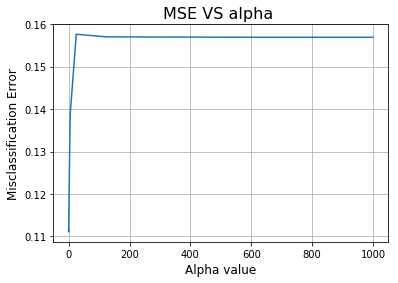

the misclassification error for each alpha value is :  [0.111 0.111 0.112 0.118 0.139 0.158 0.157 0.157 0.157]


In [39]:
from sklearn.naive_bayes import BernoulliNB # import library for NB

# creating list of alpha values
alpha_values = [0.001 , 0.01 , 0.1, 1 , 5 , 25 , 125 , 625 ,1000]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for my_alpha in alpha_values: #loop for all the alpha values
        
    scores = cross_val_score(BernoulliNB(alpha = my_alpha), X_train,y_train, cv=5,scoring='accuracy',n_jobs=-1) #Evaluate a score by cross-validation
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)


plt.xlabel('Alpha value',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS alpha ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [40]:
# training the model with the optimal alpha value 
clf = BernoulliNB(optimal_alpha)
nb=clf.fit(X_train,y_train)

In [41]:
# calculating the accuracy score of models

y_pred = clf.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("accuracy is ", acc)

accuracy is  0.8913337970929593


# To find optimal alpha with MultiinomialNB


The optimal value of alpha is 1.000000.


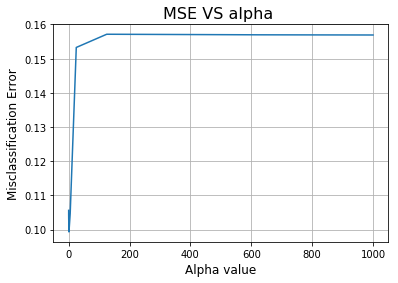

the misclassification error for each alpha value is :  [0.106 0.104 0.103 0.099 0.105 0.153 0.157 0.157 0.157]


In [42]:
from sklearn.naive_bayes import MultinomialNB # import library for NB

# creating list of alpha values
alpha_values = [0.001 , 0.01 , 0.1, 1 , 5 , 25 , 125 , 625 ,1000]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for my_alpha in alpha_values: #loop for all the alpha values
        
    scores = cross_val_score(MultinomialNB(alpha = my_alpha), X_train,y_train, cv=5,scoring='accuracy',n_jobs=-1) #Evaluate a score by cross-validation
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)


plt.xlabel('Alpha value',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS alpha ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [43]:
# training the model with the optimal alpha value 
clf = MultinomialNB(optimal_alpha)
nb=clf.fit(X_train,y_train)


In [44]:
# calculating the accuracy score of models
y_pred = clf.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("accuracy is ", acc)

accuracy is  0.9044319554790758


# To find optima alpha with GridsearchCV

In [45]:
from sklearn.naive_bayes import MultinomialNB # import library for NB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#time series split
tscv = TimeSeriesSplit(n_splits=5)
tuned_parameters = {'alpha': [0.1, 1.0, 10.0, 100.0]}


#Using GridSearchCV
model = GridSearchCV(MultinomialNB(),tuned_parameters, scoring = 'accuracy', cv=tscv,n_jobs=-1)
model.fit(X_train,y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))
print(max(model.cv_results_['mean_train_score']))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.9044319554790758
0.9223834718553461


# Feature importance  

In [46]:
# our aim is to find the word that would be impoertant than others on the basis of frequency 
# for word importance we will use log probability for each of the word
var=clf.feature_log_prob_ # var is list here which is storing the log prob score of word
var.shape # shape of list, just for understanding

(2, 60080)

In [47]:
clf.classes_ # to know about the classes which is at zero index

array(['negative', 'positive'], dtype='<U8')

In [48]:
# after knowing the class label we will separate the log prob. score of positive and negative class in two array
Narr=[]
Parr=[]

Narr=nb.feature_log_prob_[0,:] #storing in array for negative class
Parr=nb.feature_log_prob_[1,:] #storing in array for positive class

Nlist=[]
Plist=[]
# after storing the array we will sort the array in descending order for importatnt word or feature
# now we will sort with argsort that will give index instead of vector form in decreasing order
Nlist=np.argsort(Narr)[::-1] #storing sorted array of log prob score in negative list
Plist=np.argsort(Parr)[::-1] #storing sorted array of log prob score in positive list

In [49]:
#now we have two sorted list of positive and negative classes 
#we will get the words in list for accessing the important words with the help of index 
list1=count_vect.get_feature_names() #storing words in list 
for i in Nlist[0:5]: 
    print(list1[i]) 
    print(Narr[i])

tast
-4.259140441674376
like
-4.3183459093104855
product
-4.464109197230838
one
-4.768276701846101
flavor
-4.830412001694807


In [50]:
#we will get the words in list for accessing the important words with the help of index  
for i in Plist[0:5]:
    print(list1[i])
    print(Parr[i])

like
-4.427789201591445
tast
-4.5062318531512116
good
-4.637497139780368
flavor
-4.669810232159373
love
-4.694485936742957


# Confusion matrix

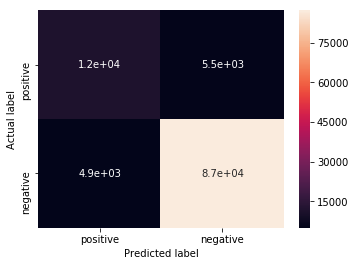

In [51]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


y_pred = clf.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [52]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print(f1_score(y_test, y_pred, average="macro")) # calculating f1score
print(precision_score(y_test, y_pred, average="macro")) # calculating precision score 
print(recall_score(y_test, y_pred, average="macro"))   # calculating recall score 

0.8166131766388309
0.8211133968215232
0.8123206226772615


In [53]:
print(cm) # printing confusion matrix

[[11604  5506]
 [ 4935 87207]]


In [54]:
#calculating some of the parameter to calculate to find tpr,tnr,fpr,fnr and accuracy of the model
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [55]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate",TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate",TNR)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate",FPR)
# False negative rate
FNR = FN/(TP+FN)
print("False negative rate",FNR)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy is",ACC)

True positive rate [0.67819988 0.94644136]
True negative rate [0.94644136 0.67819988]
False positive rate [0.05355864 0.32180012]
False negative rate [0.32180012 0.05355864]
Accuracy is [0.90443196 0.90443196]


# Naive bayes on TFIDF

In [26]:
# split the data set into train and test
X_tr, X_tes, y_train, y_test = cross_validation.train_test_split(final['CleanedText'].values, final['Score'], test_size=0.3, random_state=0)

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
X_train_tfidf = tf_idf_vect.fit_transform(X_tr)
X_test=tf_idf_vect.transform(X_tes)

# To find optimal alpha with BernoulliNB


The optimal value of alpha is 0.100000.


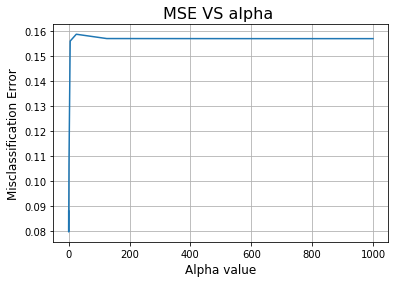

the misclassification error for each alpha value is :  [0.088 0.081 0.08  0.107 0.156 0.159 0.157 0.157 0.157]


In [45]:
from sklearn.naive_bayes import BernoulliNB # import library for NB

# creating list of alpha values
alpha_values = [0.001 , 0.01 , 0.1, 1 , 5 , 25 , 125 , 625 ,1000]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for my_alpha in alpha_values: #loop for all the alpha values
        
    scores = cross_val_score(BernoulliNB(alpha = my_alpha), X_train_tfidf,y_train, cv=10, scoring='accuracy') #Evaluate a score by cross-validation
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)


plt.xlabel('Alpha value',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS alpha ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [46]:
# training the model with the optimal alpha value 
clf = BernoulliNB(optimal_alpha)
nb=clf.fit(X_train_tfidf,y_train)

In [47]:
# calculating the accuracy score of models

y_pred = clf.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("accuracy is ", acc)

accuracy is  0.9201845275143704


# To find optimal alpha with MultinomialNB


The optimal value of alpha is 0.100000.


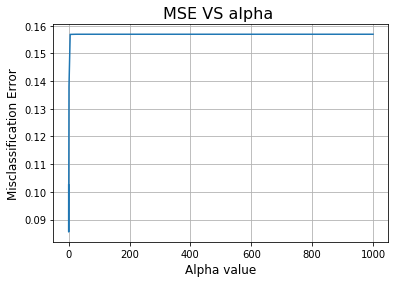

the misclassification error for each alpha value is :  [0.103 0.092 0.086 0.138 0.157 0.157 0.157 0.157 0.157]


In [48]:
from sklearn.naive_bayes import MultinomialNB # import library for NB

# creating list of alpha values
alpha_values = [0.001 , 0.01 , 0.1, 1 , 5 , 25 , 125 , 625 ,1000]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for my_alpha in alpha_values: #loop for all the alpha values
        
    scores = cross_val_score(MultinomialNB(alpha = my_alpha), X_train_tfidf,y_train, cv=5,scoring='accuracy',n_jobs=-1) #Evaluate a score by cross-validation
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)


plt.xlabel('Alpha value',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS alpha ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [49]:
# training the model with the optimal alpha value 
clf = MultinomialNB(optimal_alpha)
nb=clf.fit(X_train_tfidf,y_train)

In [50]:
# calculating the accuracy score of models

y_pred = clf.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("accuracy is ", acc)

accuracy is  0.9158184747189982


# To find optimal alpha with gridsearchCV

In [29]:
#time series split
tscv = TimeSeriesSplit(n_splits=5)
tuned_parameters = {'alpha': [0.1, 1.0, 10.0, 100.0]}


#Using GridSearchCV
model = GridSearchCV(MultinomialNB(),tuned_parameters, scoring = 'accuracy', cv=tscv,n_jobs=-1)
model.fit(X_train_tfidf,y_train)
 
print(model.best_estimator_)
print(model.score(X_test, y_test))
print(max(model.cv_results_['mean_train_score']))

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
0.9158184747189982
0.966303666535959


# Feature importance

In [34]:
# our aim is to find the word that would be impoertant than others on the basis of frequency 
# for word importance we will use log probability for each of the word
var=clf.feature_log_prob_ # var is list here which is storing the log prob score of word
var.shape # shape of list, just for understanding

(2, 305513)

In [35]:
clf.classes_ # to know about the classes which is at zero index

array(['negative', 'positive'], dtype='<U8')

In [36]:
# after knowing the class label we will separate the log prob. score of positive and negative class in two array
Narr=[]
Parr=[]

Narr=nb.feature_log_prob_[0,:] #storing in array for negative class
Parr=nb.feature_log_prob_[1,:] #storing in array for positive class

Nlist=[]
Plist=[]
# after storing the array we will sort the array in descending order for importatnt word or feature
# now we will sort with argsort that will give index instead of vector form in decreasing order
Nlist=np.argsort(Narr)[::-1] #storing sorted array of log prob score in negative list
Plist=np.argsort(Parr)[::-1] #storing sorted array of log prob score in positive list

In [37]:
#now we have two sorted list of positive and negative classes 
#we will get the words in list for accessing the important words with the help of index 
list1=tf_idf_vect.get_feature_names() #storing words in list 
for i in Nlist[0:5]: 
    print(list1[i]) 
    print(Narr[i])

tast
-0.9869814554188459
like
-0.9975685592240104
product
-1.1843335573608904
one
-1.3506376374147049
would
-1.420782238069613


In [38]:
#we will get the words in list for accessing the important words with the help of index  
for i in Plist[0:5]:
    print(list1[i])
    print(Parr[i])

like
-1.1726382955546608
tast
-1.2034564578084535
good
-1.2634447420840136
love
-1.2649602183238589
great
-1.2961363572971933


# Confusion matrix

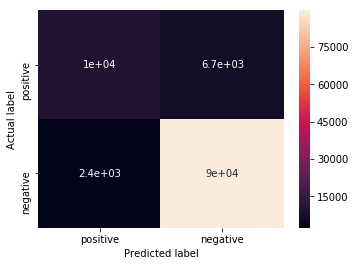

In [39]:
#plotting confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

y_pred = clf.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Accuracy

In [40]:
acc=accuracy_score(y_test, y_pred) #calculating accuracy
print("accuracy is ", acc)

accuracy is  0.916779555523011


In [41]:
# calculating some of the parameter f1score , precision score and recall score 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))   

0.8240940044679097
0.87148538392326
0.7916564326088258


In [42]:
print(cm) # printing confusion matrix

[[10428  6682]
 [ 2410 89732]]


In [43]:
# calculating some of the parameter to calculate tpr,tnr,fpr,fnr and accuracy
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [44]:
# true positive rate
TPR = TP/(TP+FN)
print("True positive rate",TPR)
# true negative rate
TNR = TN/(TN+FP) 
print("True negative rate",TNR)
# false positive rate
FPR = FP/(FP+TN)
print("False positive rate",FPR)
# False negative rate
FNR = FN/(TP+FN)
print("False negative rate",FNR)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy is",ACC)

True positive rate [0.60946815 0.97384472]
True negative rate [0.97384472 0.60946815]
False positive rate [0.02615528 0.39053185]
False negative rate [0.39053185 0.02615528]
Accuracy is [0.91677956 0.91677956]


# Table with model,optimal alpha,train error and test error

In [57]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Optimal alpha", "Train error", "Test error"]

x.add_row(["BernoulliNB(BOW)", 0.01,0.111,11])
x.add_row(["MultinomialNB(BOW)",1.00,0.099,10])
x.add_row(["GridsearchCV(BOW)",1.0,0.08,10])
x.add_row(["BernoulliNB(tfidf)",0.100,0.08,8])
x.add_row(["MultinomialNB(tfidf)",0.10,0.08,9])
x.add_row(["GridsearchCV(tfidf)",0.1,0.04,9])


print(x)

+----------------------+---------------+-------------+------------+
|        Model         | Optimal alpha | Train error | Test error |
+----------------------+---------------+-------------+------------+
|   BernoulliNB(BOW)   |      0.01     |    0.111    |     11     |
|  MultinomialNB(BOW)  |      1.0      |    0.099    |     10     |
|  GridsearchCV(BOW)   |      1.0      |     0.08    |     10     |
|  BernoulliNB(tfidf)  |      0.1      |     0.08    |     8      |
| MultinomialNB(tfidf) |      0.1      |     0.08    |     9      |
| GridsearchCV(tfidf)  |      0.1      |     0.04    |     9      |
+----------------------+---------------+-------------+------------+


# Observations

1. As per my project, i have used amazon fine food reviews dataset which contains of reviews in text, may bee the reviews will be positivee and negative reviews, we will identify the positive and negative reviews according to the score or rating of that review. 
2. So let's understand the objective first, we have to apply naive bayes on amazon fine food reviews dataset and after using naive bayes we have to find optimal alpha using cross validation then we also have to find the feature importance of both positive and negative reviews mean which positive and negative word are the most important word in our entire reviews dataset. after finding feature importance,we will calculate accuracy of that model and also we have to calculate precision recall and f1_score after calculating we will plot confusion matrix, with the help of confusion matrix we will calculate TPR,FPR,FNR and TNR. so it was the objective of this assignment.
3. As i have mentioned the objective above so we start the procedure to complete the assignment, as usual i have load the reviews dataset and after that we reject the rating 3 because as we have to process only positive reviews and negative reviews, the i have cleaned the data for better performance of machine learning algorithm as we all know without cleaning and preprocessing of data, machine learning algorithm can not perform the operation on raw data.
4. After cleaning the data we proprocess the data like removing html tags, removing puntuation and removing special characters then we split the data and we use bag of words to process the naive bayes algorithm then we applied algorithm to find optimall alpha then we trained the algorithm with the help of optimal alpha after training the model we will calculate the accuracy of our naive bayes model on unseen data because if we don't test the model we will not be able to say it is predicting correct or not or performance measured by accuracy of model .
5. Now we will find the feature importance means whch word is more important of both positive and negative reviews. most frequent words will be the most important words in feature importance.
6. Then we find the precision recall and f1score as mentoned in the objective of this assignment, Precision is the ratio of correctly predicted positive observations to the total predicted positive observations, Recall is the ratio of correctly predicted positive observations to the all observations in actual class and f1score the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account
7. fter calculating precion recall and f1score we will plot confusion matrix to understand the accuracy of model clearly. A confusion matrix is a technique for summarizing the performance of a classification algorithm. A confusion matrix is a summary of prediction results on a classification problem.
8. With the help of confusion matrix we will calculate the true positive rate (TPR), true negative rate (TNR),False positive rate (FPR) and False negative rate(FNR).
9. Hence we will do the same procedure for rest of the process like tfidf, avgw2v and tfidfw2v.